In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pystan
import scipy.special as ss
import scipy.stats as st
import seaborn as sns

In [3]:
sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

We have set up a simple, mock data set to see if we could possibly detect pre-GRB resonant shattering flares in the aggregate even if there is no confident detection in any particular time series.  

We will generate time-series of counts that are Poisson distributed with some rate per unit time:
$$
n(t) \sim P(\lambda(t)).
$$
The rate, $\lambda(t)$, will be a sum of a constant background rate and a Gaussian surrounding the start time of the flare with width one time unit:
$$
\lambda(t) = \mathrm{const} + \frac{A}{\sqrt{2\pi}} \exp\left[ -\frac{1}{2} \left(t - t_0 \right)^2 \right].
$$

With this choice of parameterization, $A$ is the total number of expected counts in the flare.  Set the origin of time ($t=0$) to the GRB.  Suppose that physics tells us the rough distribution of pre-GRB times for the shattering flares is 
$$
t_0 \sim N(-5, 2)
$$
and that the typical amplitude is $5 \pm 2$ counts:
$$
A \sim N(5, 2)
$$
(but note that $A > 0$).  With this distribution almost all observations will have (on average) at least one count, and probably many more, from the flare.  Further, we will suppose that the background rate is always 1, and that we take 15 measurements of the count leading up to the GRB.

In [4]:
def sigwt(ts, mu, sigma):
    return 0.5*(ss.erf((mu-ts[:-1])/(sigma*sqrt(2))) - ss.erf((mu-ts[1:])/(sigma*sqrt(2))))

In [23]:
nbins = 15
ts = linspace(-nbins, 0, nbins+1)
def generate(nobs):
    data = []
    for i in range(nobs):
        t0 = 1.0
        while t0 > 0:
            t0 = random.normal(-5, 2)
        A = -1.0
        while A < 0:
            A = random.normal(5, 2)
        counts = random.poisson(3.0*ones(15) + A*sigwt(ts, t0, 1.0))
        data.append(counts)
    return data

An example of the normalised counts that would be obtained for $t_0 = -5$:

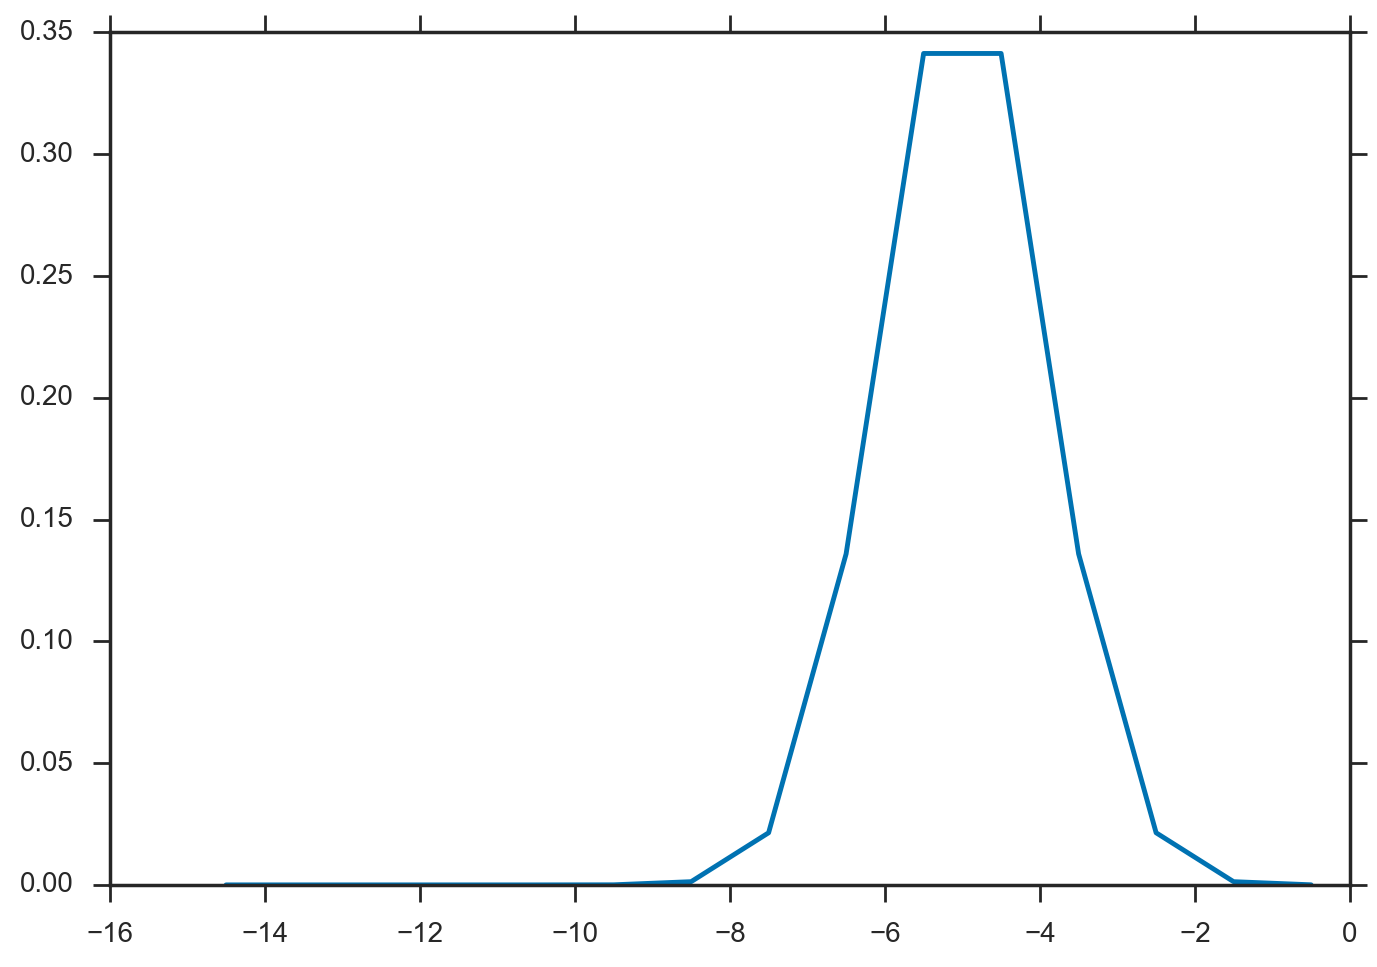

In [24]:
plot(0.5*(ts[:-1]+ts[1:]), sigwt(ts, -5, 1))

Generate some good data:

In [25]:
ctdata = generate(30)

Let's plot the sum of all the counts and the individual curves, to see if we can find an obvious peak:

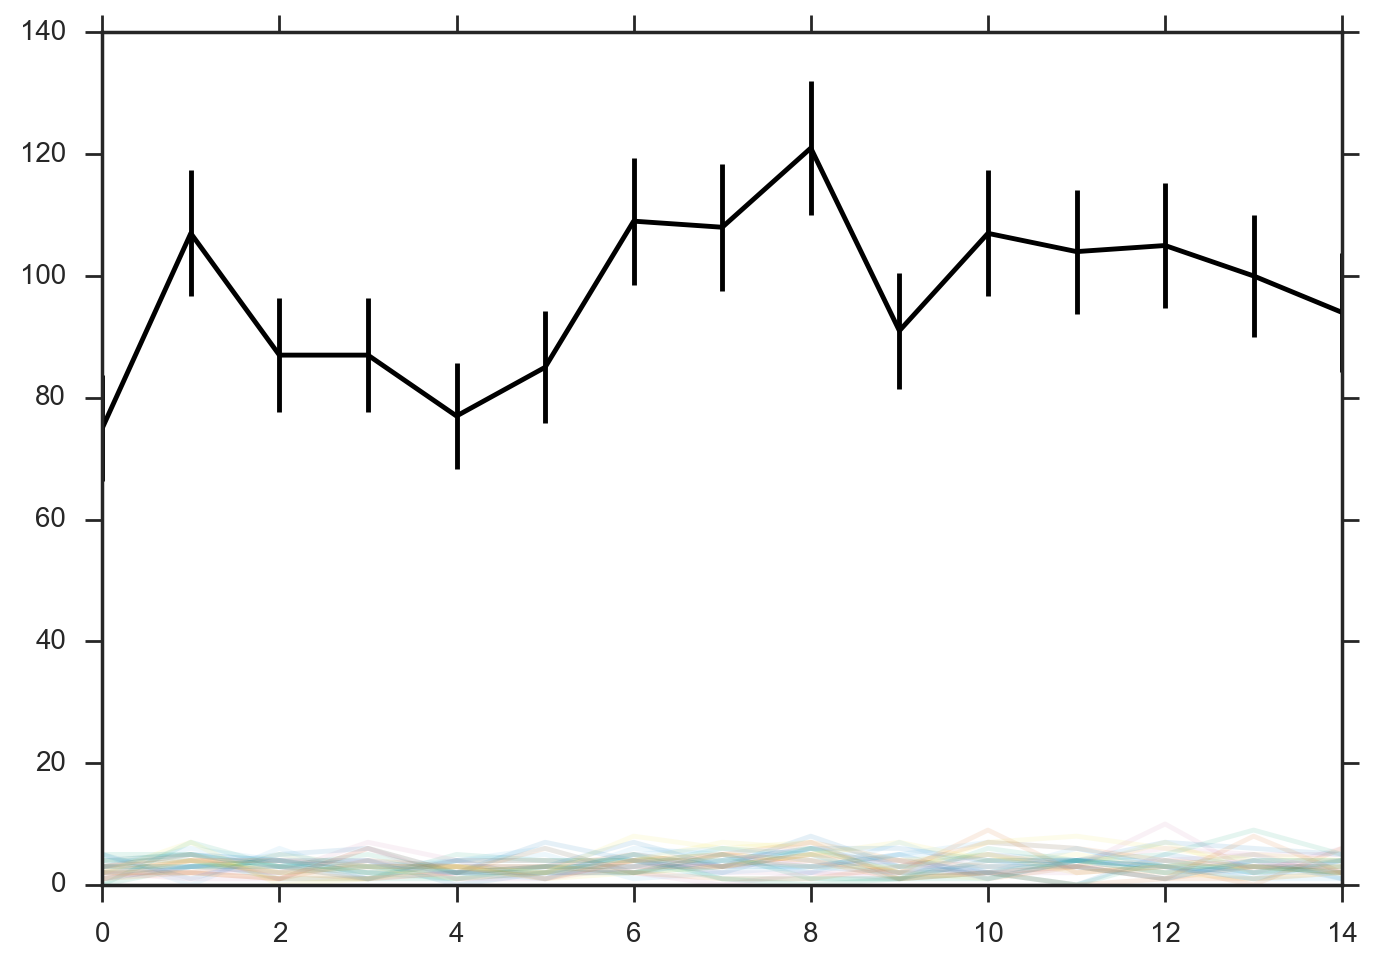

In [26]:
totals = sum(array(ctdata), axis=0)
errorbar(arange(totals.shape[0]), totals, sqrt(totals), fmt='-k')
for d in ctdata:
    plot(d, alpha=0.1)

Let's look for a real signal by summing the totals, weighted by the N(-5, 2) distribution for the position of the peak.  We compute the variance of our statistics in a way that is not quite correct: we assume that the totals in each time bin are distributed Poisson (this is correct) and so the variance is equal to the count (this is not quite correct, but reasonable if the number of counts is large).  Then the variance of the statistic just follows from the sum and product rules for variances.

In [27]:
wts = sigwt(ts, -5, 2) # Not really what sigwt is for, but still works
wts = wts / sum(wts)
sig = sum(totals*wts)
var_sig = sum(totals*wts*wts)
bg = sum(totals*(1-wts))/sum(1-wts)
var_bg = sum(totals*(1-wts)*(1-wts))/square(sum(1-wts))
print('sig = {:.1f}, bg = {:.1f}, sigma = {:.1f}'.format(sig, bg, (sig-bg)/sqrt(var_sig + var_bg)))

sig = 104.5, bg = 96.6, sigma = 1.7


That's not much of a detection....  The problem is that the width of the distribution of possible signal locations is much wider than the width of a signal itself.  So, if we don't fit the location of the signal in the data, then we have, by necessity, to average over a lot of background....  So, we turn to a hierarchical model, encoded in `flaresearch.stan`.  It uses the "physical" priors on the signal location and imposes a Gaussian prior on the amplitude; if we can bound the mean of that Gaussian significantly above zero, then we have a detection in the aggregate, even if not in any particular instance.

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c205d2c7016fc18606c0df9b5227c0d5 NOW.


Inference for Stan model: anon_model_c205d2c7016fc18606c0df9b5227c0d5.
4 chains, each with iter=8000; warmup=4000; thin=4; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bg[0]       2.67    0.01   0.46   1.85   2.36   2.66   2.96   3.61   1890    1.0
bg[1]       2.79  7.9e-3   0.45   1.97   2.47   2.77   3.08    3.7   3242    1.0
bg[2]       2.68  7.5e-3   0.44   1.88   2.37   2.66   2.98   3.61   3454    1.0
bg[3]       2.76    0.01   0.47   1.91   2.43   2.73   3.06   3.69   1502    1.0
bg[4]       2.69    0.01   0.46   1.85   2.37   2.67   2.99   3.64   1510    1.0
bg[5]       3.27  8.1e-3   0.49   2.37   2.93   3.24   3.58    4.3   3690    1.0
bg[6]       3.08  9.2e-3   0.48   2.23   2.75   3.06   3.39   4.08   2702    1.0
bg[7]       2.08  6.9e-3    0.4   1.35   1.81   2.05   2.33   2.94   3308    1.0
bg[8]       2.53  7.3e-3   0.44   1.73   2.22    2.5   2.82   3.47   3636    1.0
b

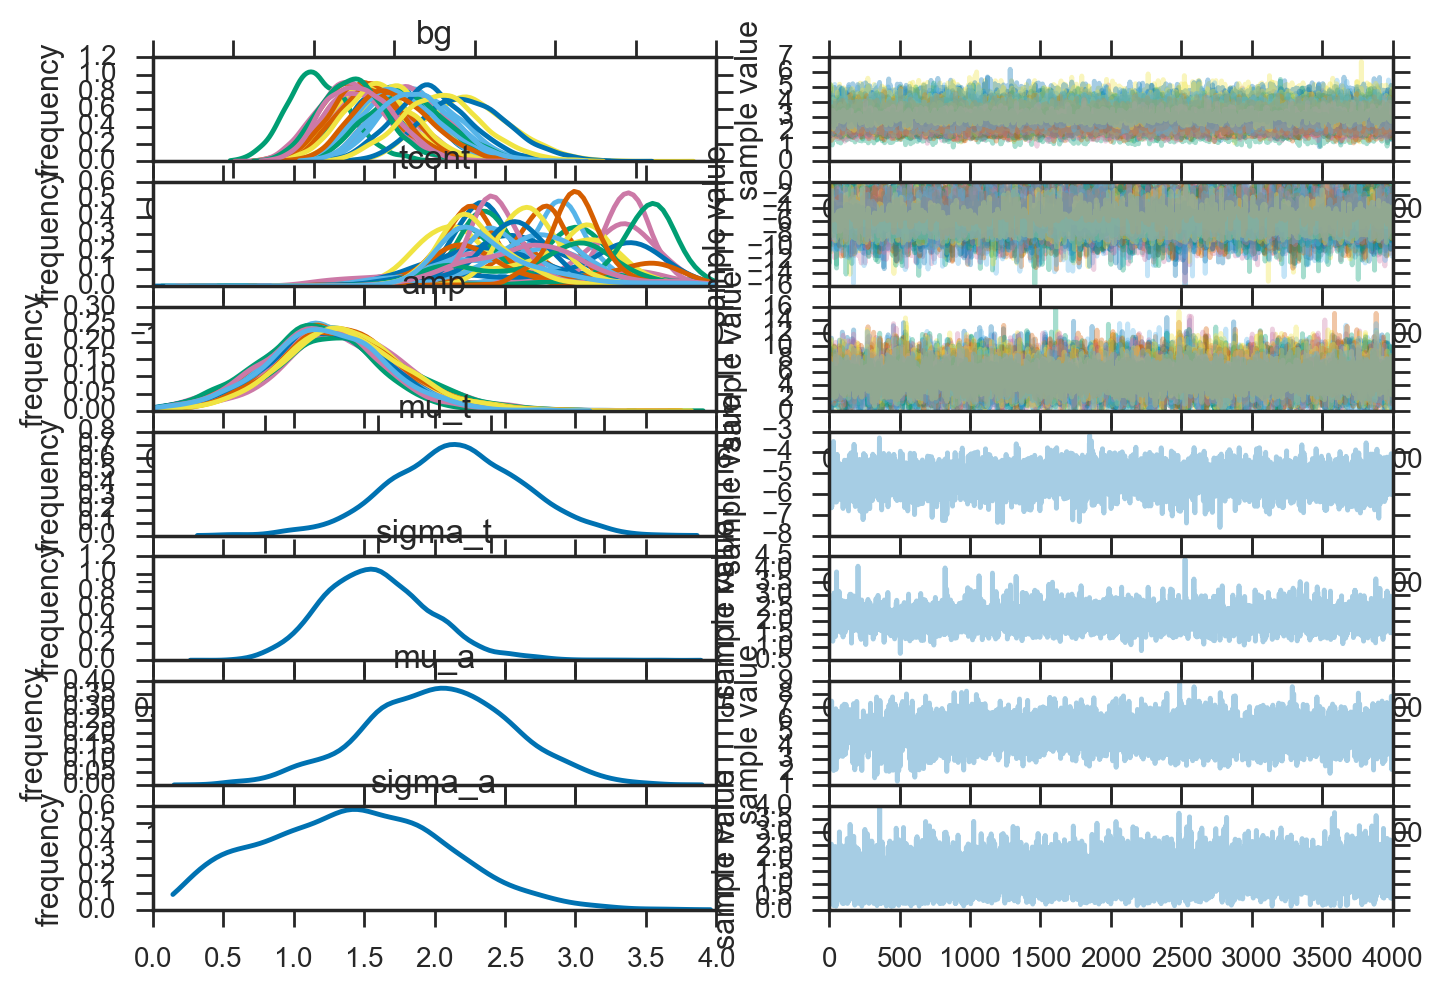

In [32]:
data = {'nt': nbins,
        'nobs': len(ctdata),
        'cts': ctdata}
fit = pystan.stan(file='flaresearch.stan', data=data, iter=8000, thin=4)
fit.plot()
chain = fit.extract(permuted=True)
fit

Whereas before we had a $\sim 2 \, \sigma$ "detection," here we see that we have clear evidence that $\mu_a$ (the centre of the amplitude distribution) is much larger than 0:

/Users/farr/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


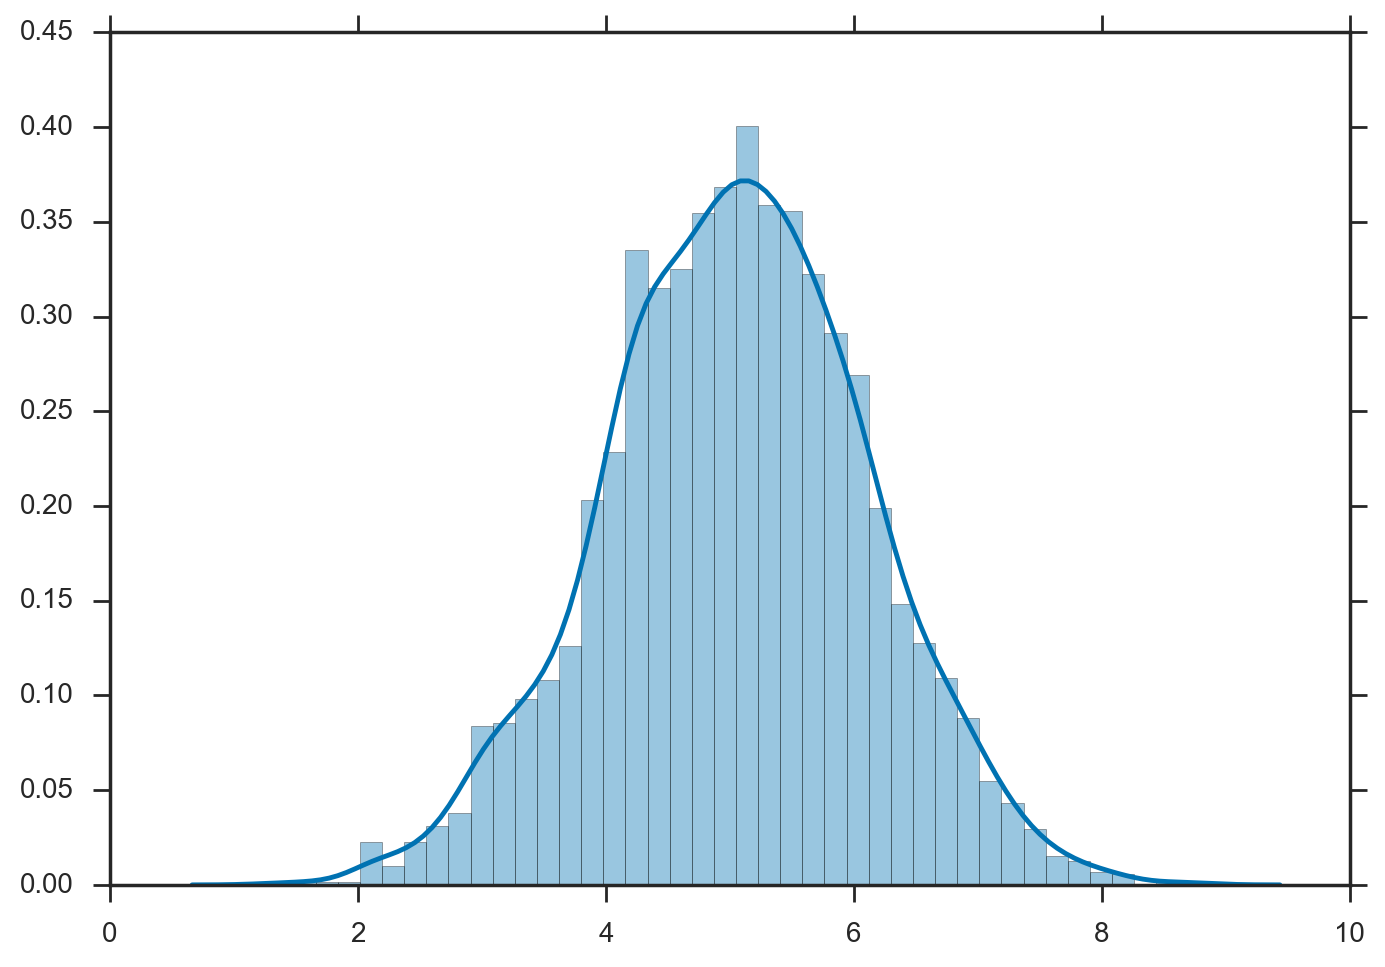

In [33]:
sns.distplot(chain['mu_a'])

This looks pretty Gaussian, so for a quick measure of detection significance, let's compute how many sigma we are from zero:

In [34]:
m = mean(chain['mu_a'])
s = std(chain['mu_a'])
print("We have a {:.1f}-sigma detection.".format(m/s))

We have a 4.8-sigma detection.


The background fits look reasonable:

/Users/farr/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


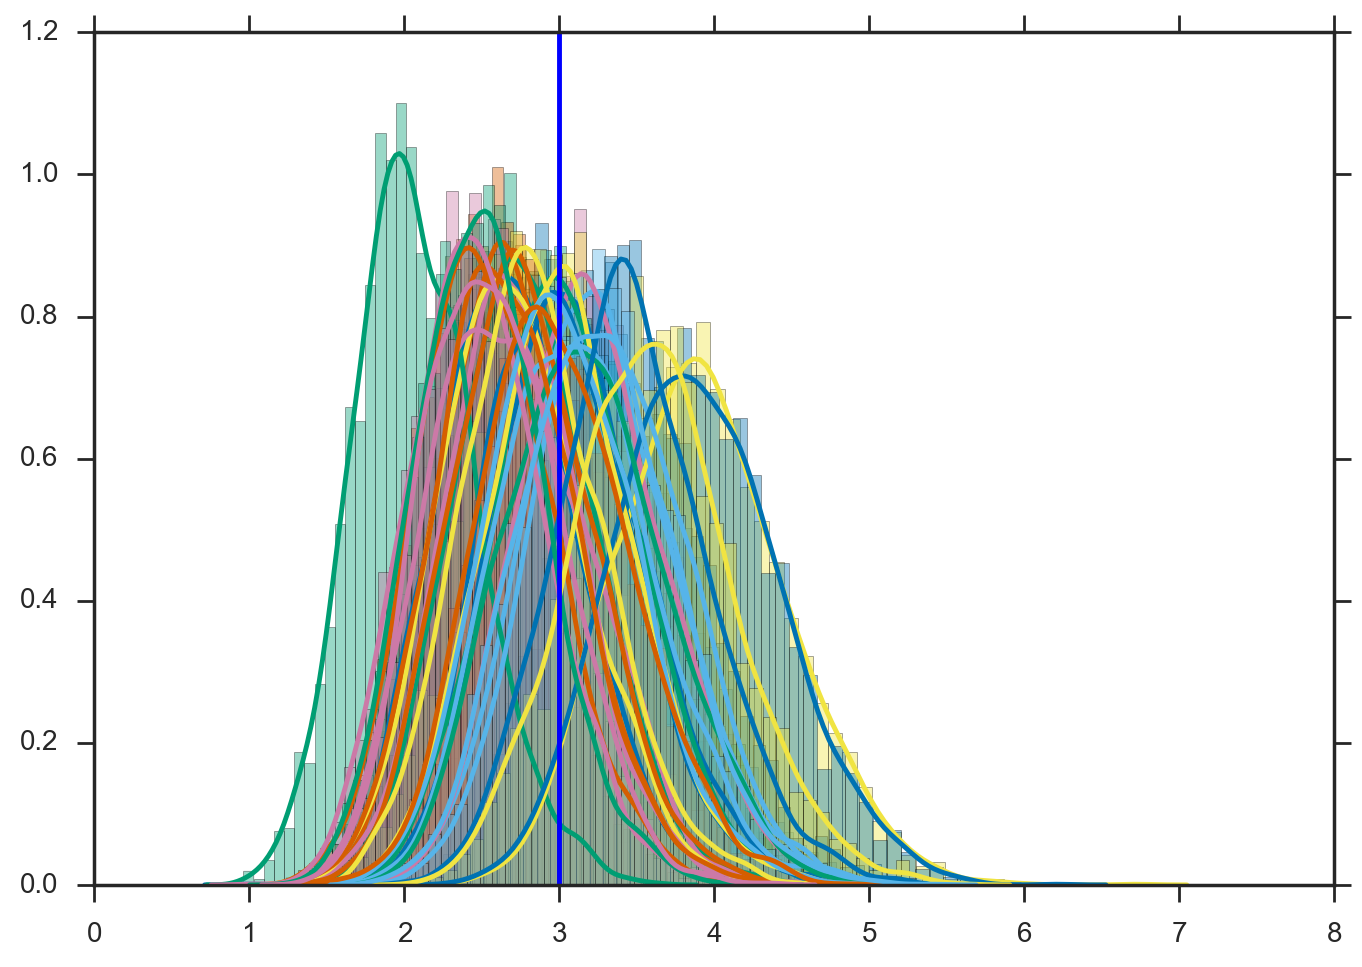

In [36]:
for i in range(len(ctdata)):
    sns.distplot(chain['bg'][:,i])
axvline(3)

Here are the actual amplitudes of the flares, observation by observation (we don't learn much more than that they follow the inferred distribution of amplitudes):

/Users/farr/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


Best single detection of a flare is 3.1 sigma


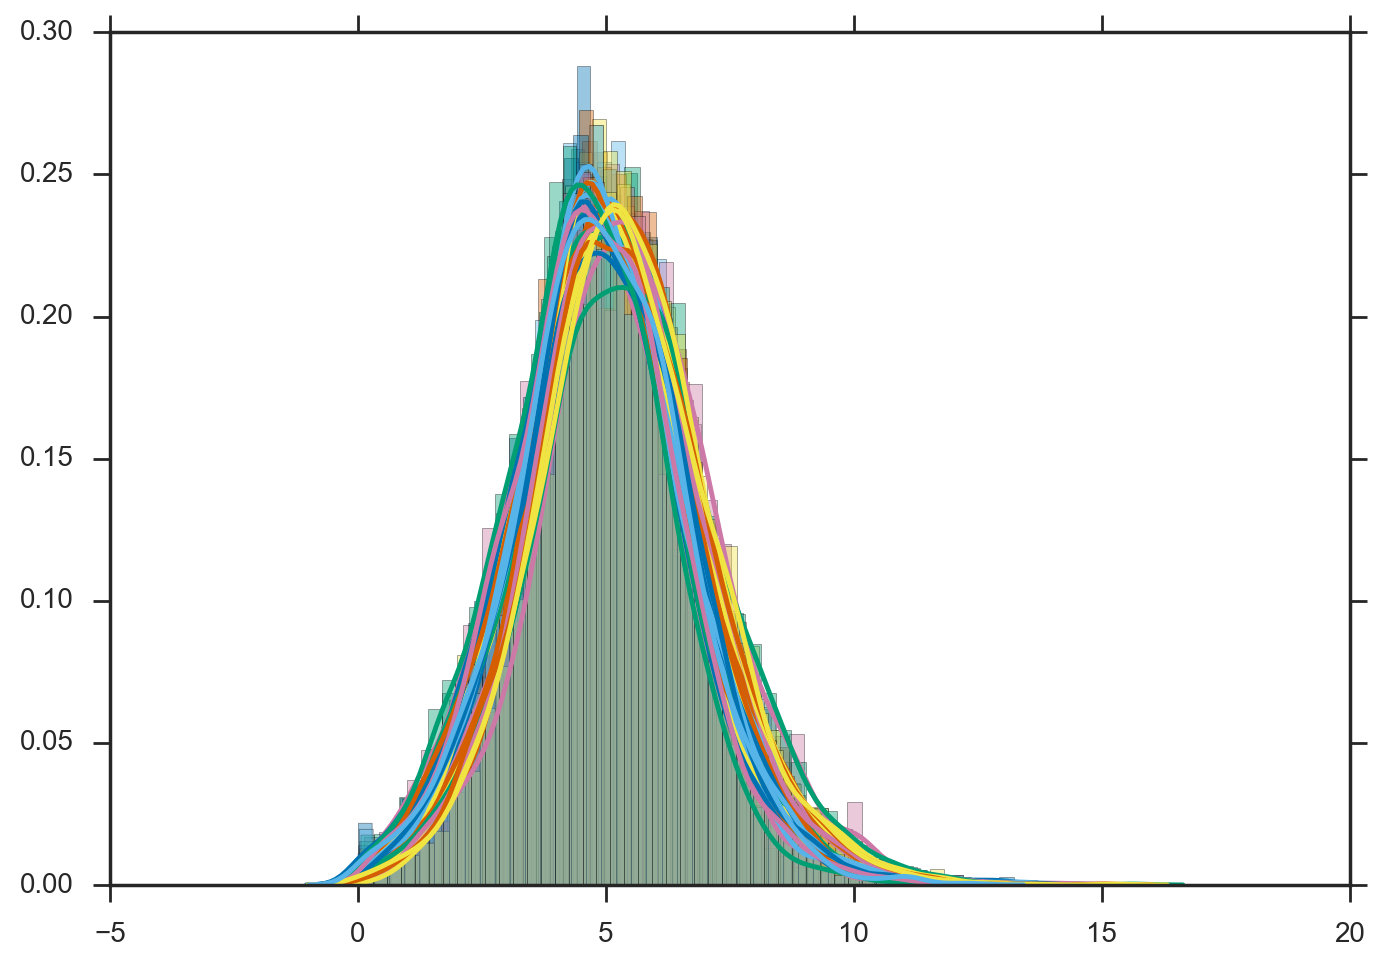

In [38]:
best_sigma = -np.inf
for i in range(len(ctdata)):
    sns.distplot(chain['amp'][:,i])
    best_sigma = max(best_sigma, mean(chain['amp'][:,i])/std(chain['amp'][:,i]))
print('Best single detection of a flare is {:.1f} sigma'.format(best_sigma))

And so on....